In [2]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite.tigramite import plotting as tp
from tigramite.tigramite.pcmci import PCMCI
from tigramite.tigramite.independence_tests import ParCorr
import tigramite.tigramite.data_processing as pp

In [27]:
data = np.load('spi12.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(data[i,j,-1]):
        #if not data[i,j,-1]<0:    
            result.append(data[i,j,11:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [11]:
from statsmodels.tsa.stattools import adfuller

In [14]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

NameError: name 'X' is not defined

In [28]:
#result = pf.deseasonalize(np.array(result))
n_components = 29

result = np.matrix(result)
result = result.transpose()
data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

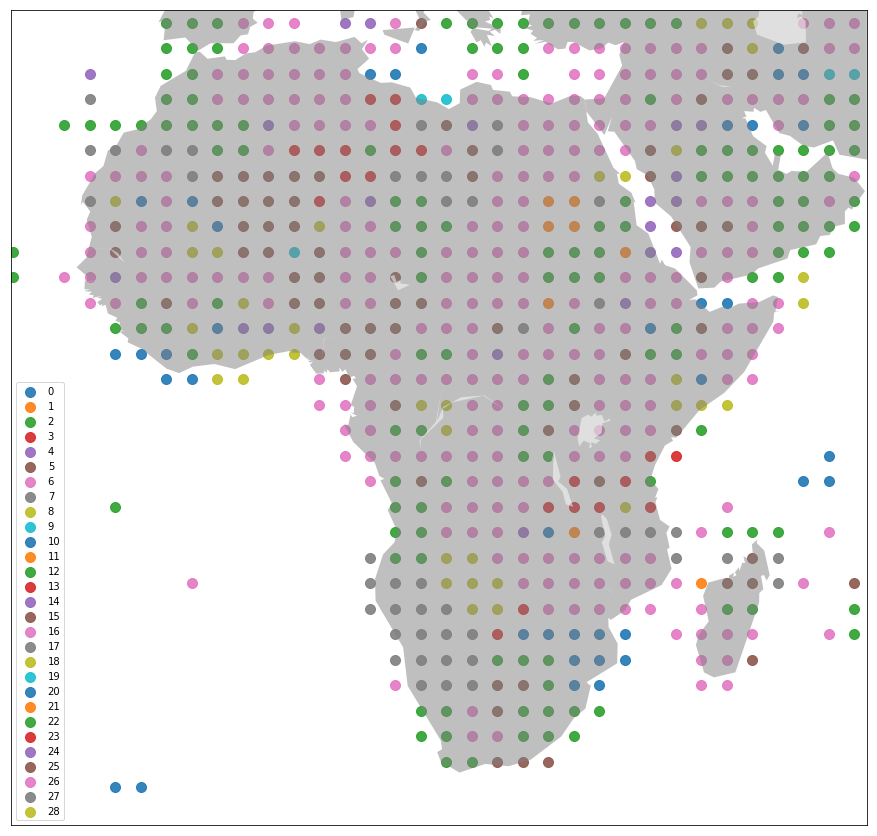

In [29]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)


for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()

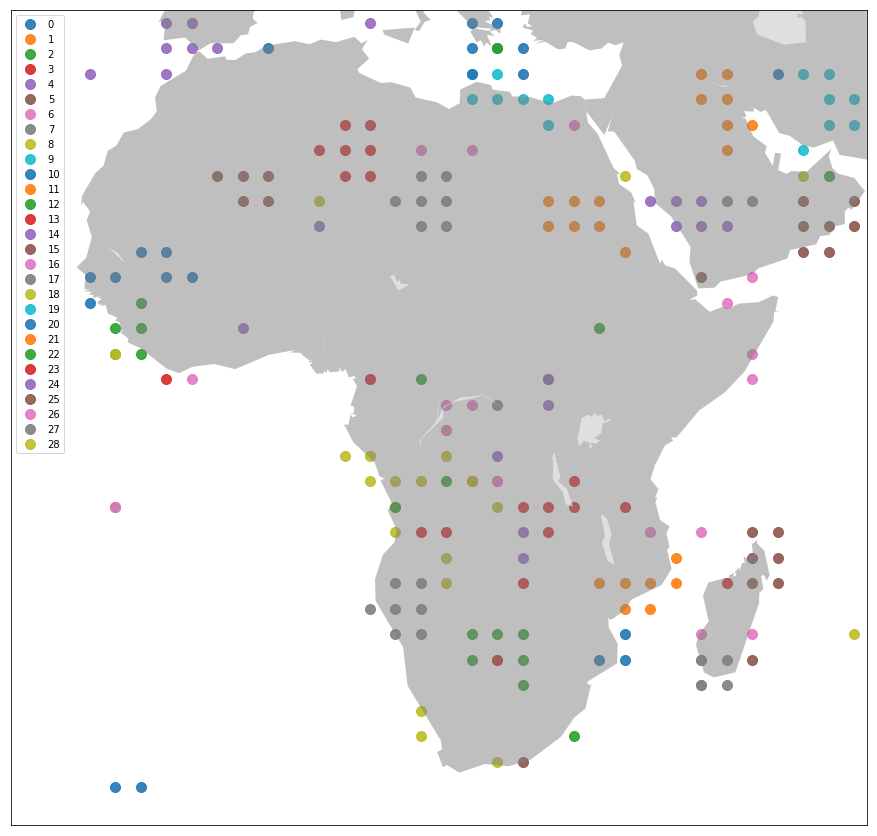

In [30]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)

limit = 0.99

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()

In [31]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [32]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results['val_matrix'][0]

array([[ 0.        ,  0.56959494, -0.12284568],
       [-0.62275374, -0.23059866, -0.32426764],
       [-0.27574855, -0.01468601,  0.05768944],
       [ 0.66624554,  0.34144644, -0.03677402]])

In [205]:
results['p_matrix'][0]

array([[1.00000000e+00, 1.62700730e-15, 6.16524070e-01],
       [1.50754287e-05, 1.89431622e-01, 2.34549809e-02],
       [3.56708457e-01, 6.25627239e-02, 5.98333191e-01],
       [6.38928879e-05, 4.61407815e-01, 2.92440381e-02],
       [1.50094525e-02, 5.42596167e-01, 3.79618330e-01],
       [3.29034028e-06, 7.68837371e-01, 4.50603338e-01]])

In [33]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 24 link(s):
        (0 -1): pval = 0.00000 | val = 0.767
        (22 0): pval = 0.00000 | val = -0.287
        (14 0): pval = 0.00000 | val = 0.202
        (17 0): pval = 0.00000 | val = 0.199
        (15 0): pval = 0.00000 | val = 0.190
        (0 -2): pval = 0.00000 | val = -0.175
        (2 0): pval = 0.00000 | val = -0.174
        (25 0): pval = 0.00001 | val = 0.159
        (9 0): pval = 0.00001 | val = 0.156
        (28 0): pval = 0.00010 | val = -0.137
        (20 0): pval = 0.00015 | val = -0.133
        (23 0): pval = 0.00031 | val = -0.127
        (21 -2): pval = 0.00046 | val = -0.123
        (21 -1): pval = 0.00051 | val = 0.122
        (27 0): pval = 0.00117 | val = 0.114
        (21 0): pval = 0.00149 | val = 0.111
        (14 -1): pval = 0.00291 | val = 0.105
        (11 0): pval = 0.00728 | val = -0.094
        (12 0): pval = 0.00864 | val = -0.092
        (18 -1): pval = 0.02450 | val = -0.079
        (26 0): p

In [34]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 16 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.767
        (22 0): pval = 0.00000 | qval = 0.00000 | val = -0.287
        (14 0): pval = 0.00000 | qval = 0.00000 | val = 0.202
        (17 0): pval = 0.00000 | qval = 0.00000 | val = 0.199
        (15 0): pval = 0.00000 | qval = 0.00000 | val = 0.190
        (0 -2): pval = 0.00000 | qval = 0.00003 | val = -0.175
        (2 0): pval = 0.00000 | qval = 0.00000 | val = -0.174
        (25 0): pval = 0.00001 | qval = 0.00001 | val = 0.159
        (9 0): pval = 0.00001 | qval = 0.00001 | val = 0.156
        (28 0): pval = 0.00010 | qval = 0.00010 | val = -0.137
        (20 0): pval = 0.00015 | qval = 0.00015 | val = -0.133
        (23 0): pval = 0.00031 | qval = 0.00031 | val = -0.127
        (27 0): pval = 0.00117 | qval = 0.00117 | val = 0.114
        (21 0): pval = 0.00149 | qval = 0.00149 | val = 0.111
        (11 0): pval = 0.00728 | qval = 0.00728 | val = -

In [20]:
q_matrix

array([[[1.00000000e+000, 5.16742538e-071, 6.99701531e-004],
        [3.32497101e-090, 5.26059586e-011, 7.07821612e-021],
        [6.23034078e-016, 6.94947659e-001, 1.30603054e-001],
        [1.75768077e-107, 4.26053373e-023, 3.34060647e-001]],

       [[3.32497101e-090, 4.33255733e-004, 2.13855987e-013],
        [1.00000000e+000, 4.59608965e-073, 2.33230542e-019],
        [4.65546030e-005, 2.92151207e-014, 3.00481062e-002],
        [5.57229167e-065, 2.08652545e-025, 5.27028087e-007]],

       [[6.23034078e-016, 2.94780971e-006, 2.17343152e-002],
        [4.65546030e-005, 4.03807600e-012, 6.33817892e-003],
        [1.00000000e+000, 3.68042178e-009, 1.39762628e-001],
        [2.38861331e-005, 6.81490727e-001, 2.67210476e-001]],

       [[1.75768077e-107, 1.39929852e-011, 1.88697580e-001],
        [5.57229167e-065, 2.94780971e-006, 6.81490727e-001],
        [2.38861331e-005, 5.48682867e-004, 7.54950412e-001],
        [1.00000000e+000, 1.53121518e-003, 8.74074419e-022]]])

In [35]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f29f6683c50>)

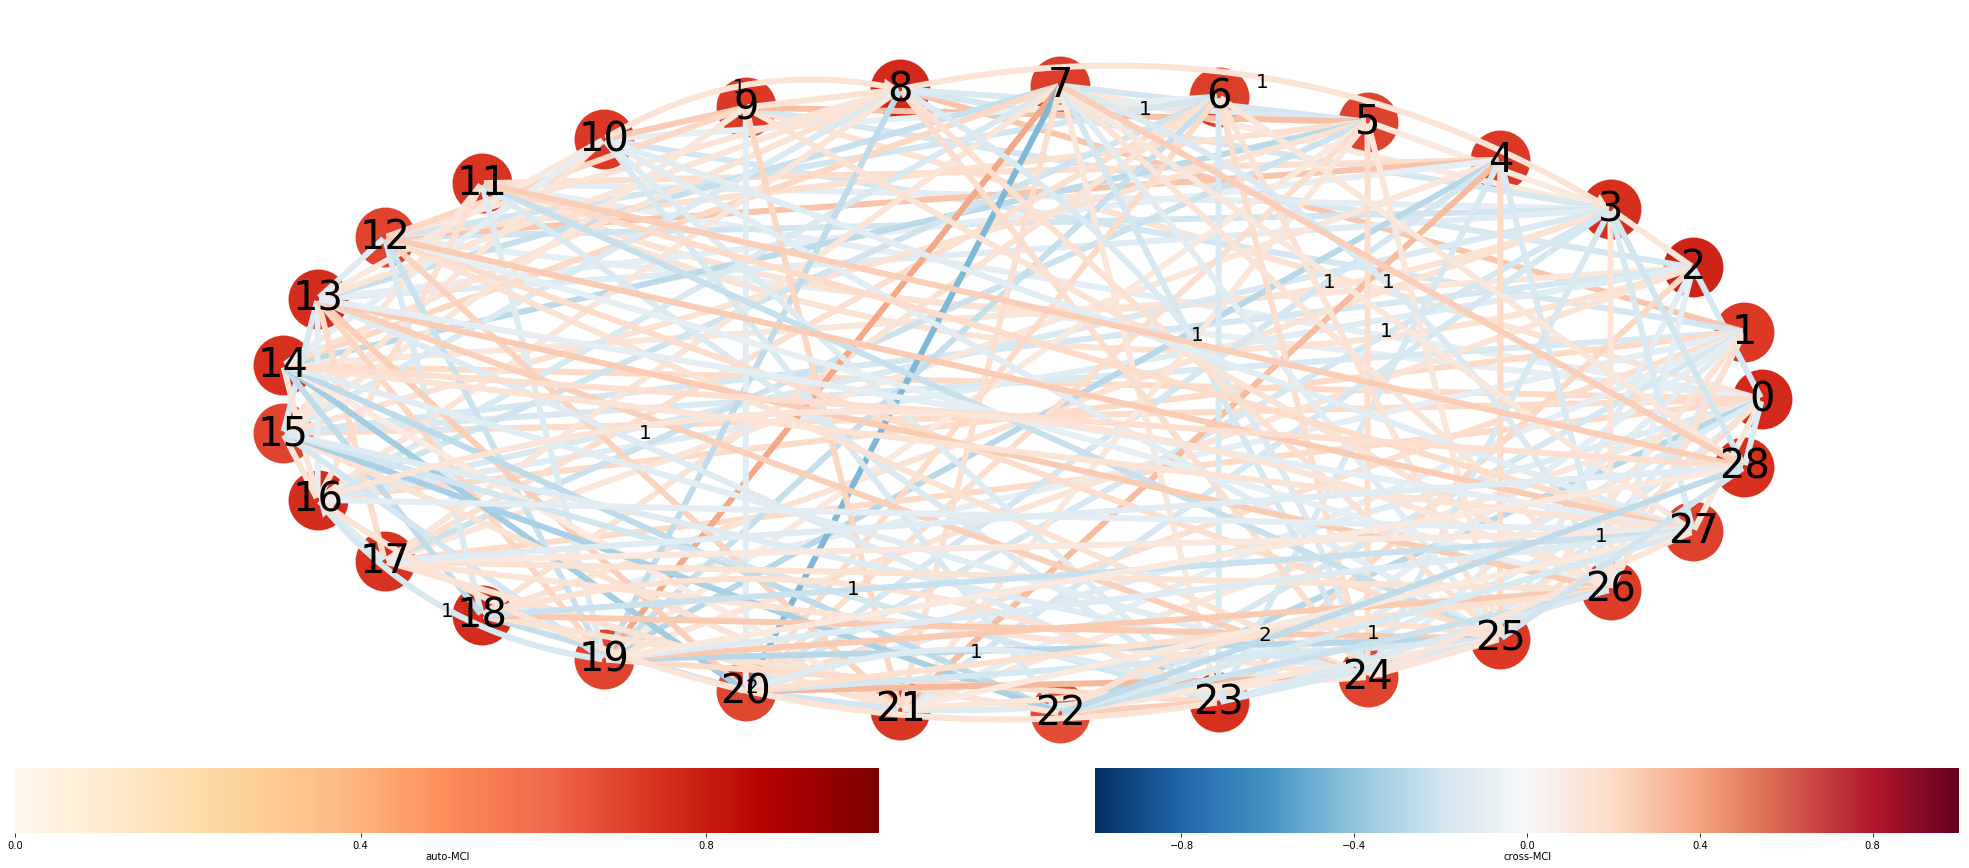

In [36]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

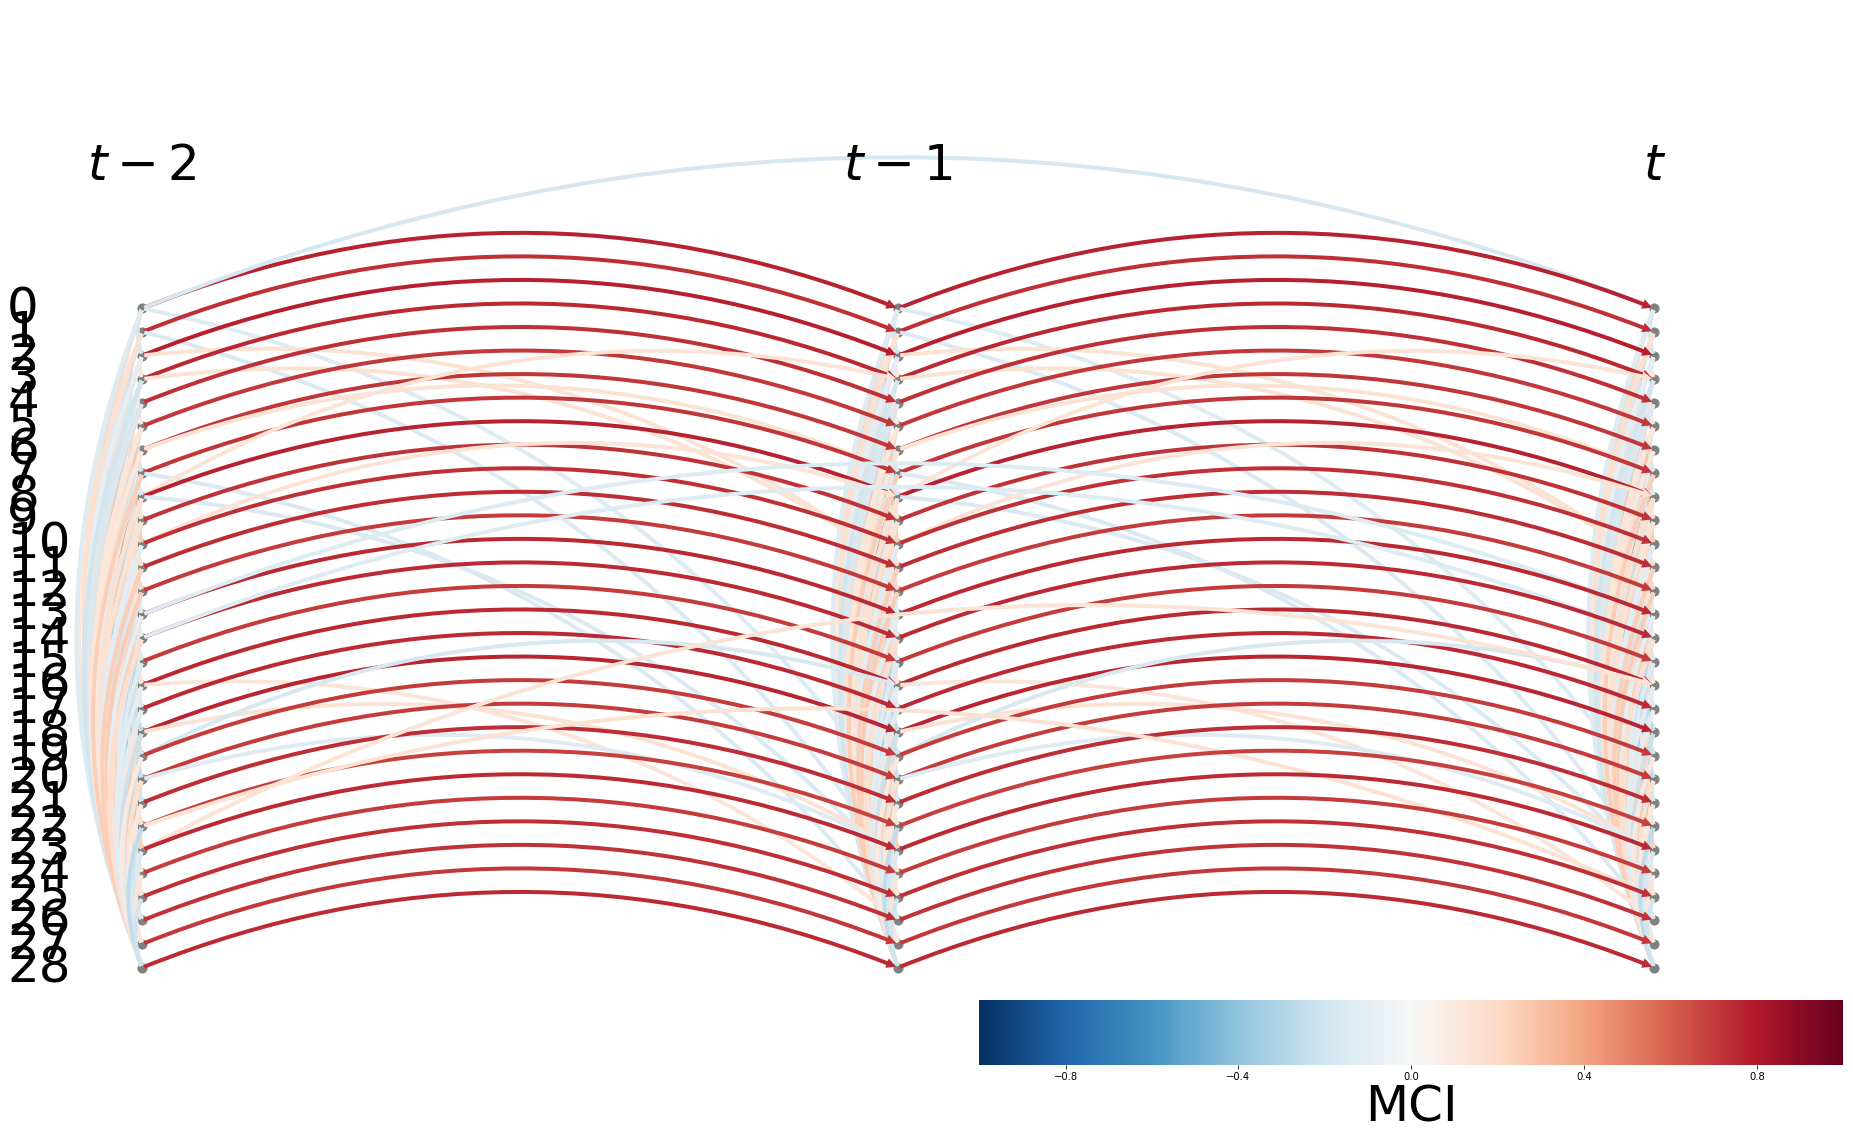

In [37]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )

# SPI for World

In [6]:
f_pre = Dataset('pdsi.mon.mean.selfcalibrated.nc')
data = f_pre.variables['pdsi']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
data = np.swapaxes(data,0,2)


In [7]:
result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not data[i,j,-1]<-9.0e+4:
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [8]:
n_components = 10

result = np.matrix(result)
result = result.transpose()
data = pd.DataFrame(result)

scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

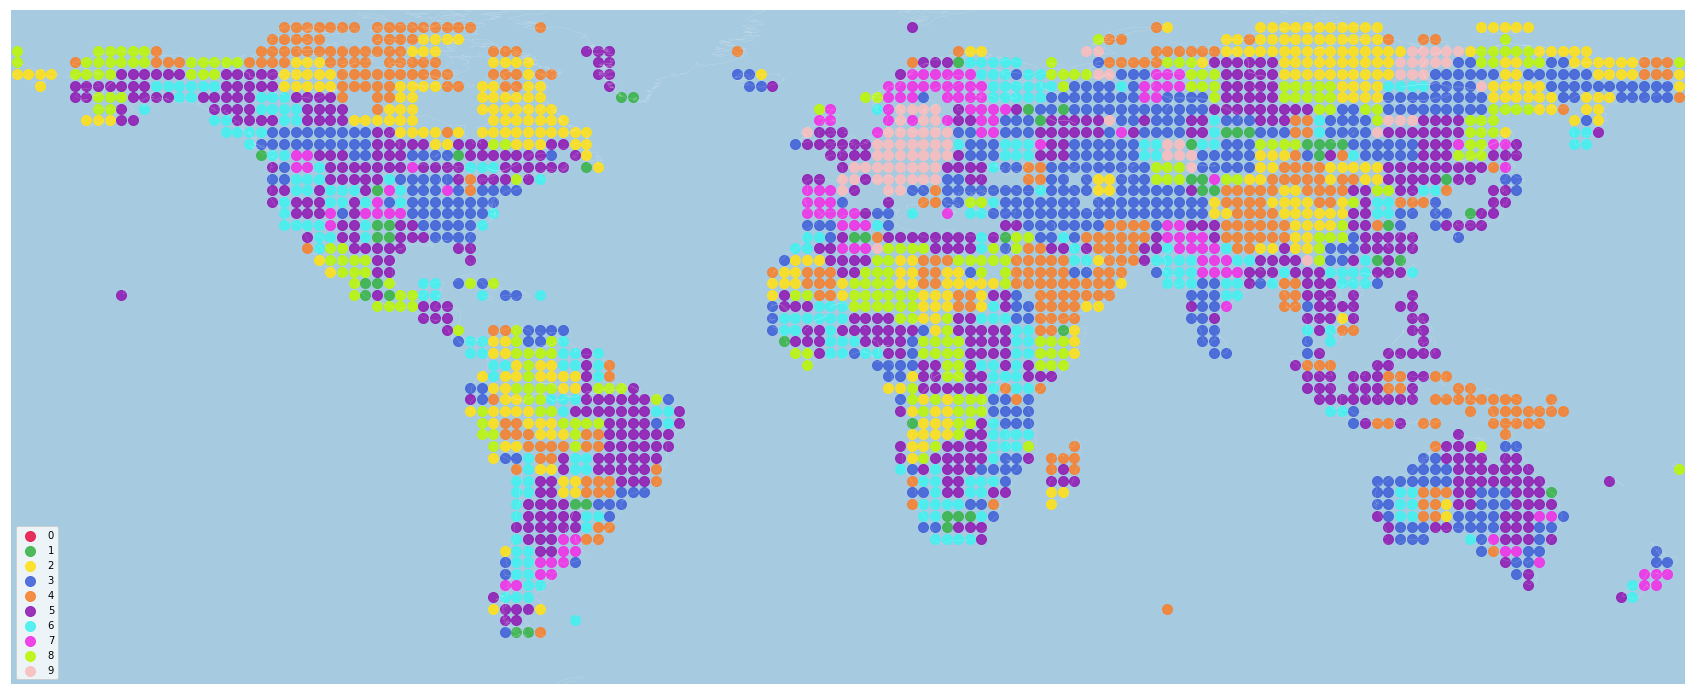

In [9]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i, c = colors[i])

    
plt.legend()
plt.show()

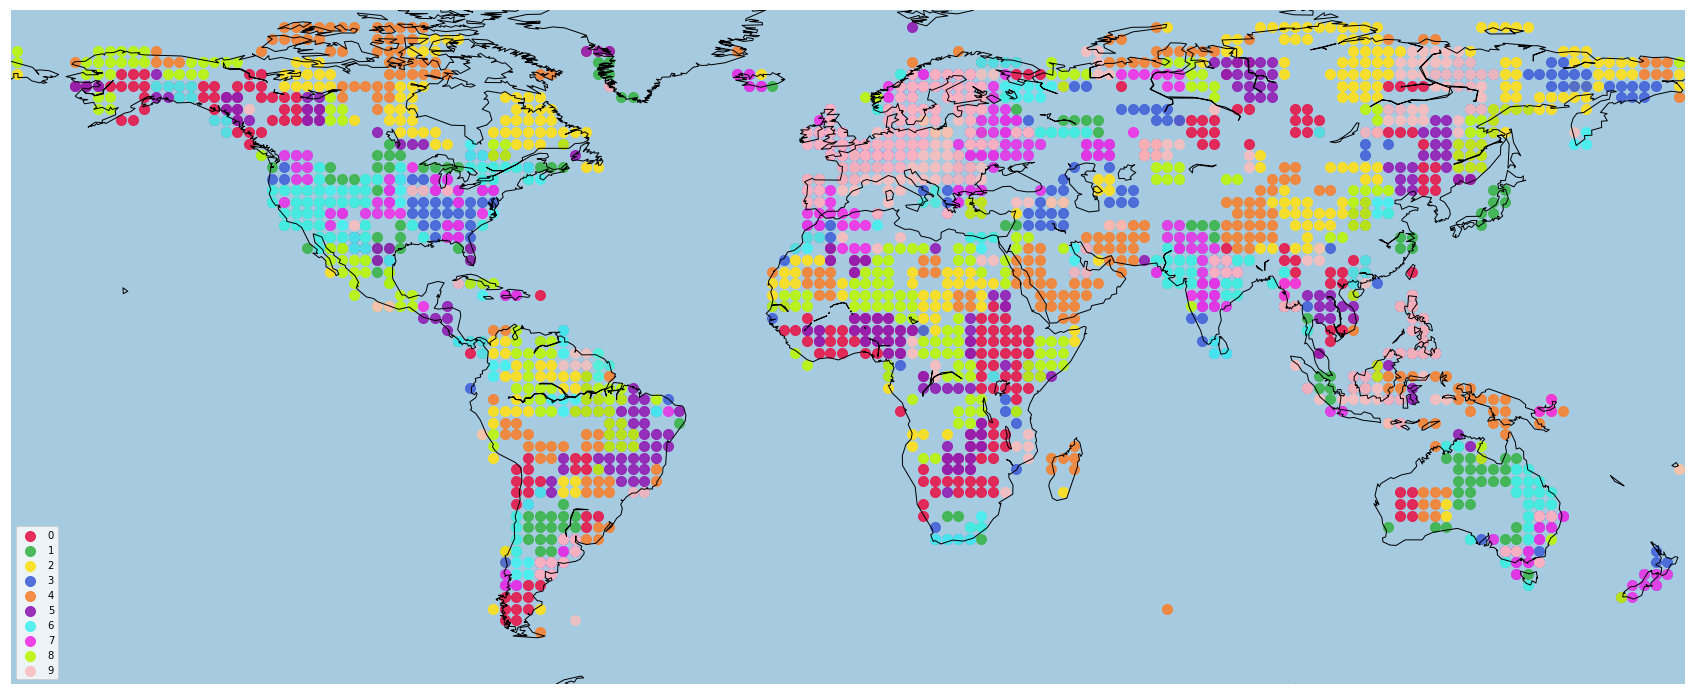

In [10]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=1, color="black")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i, c = colors[i])

    
plt.legend()
plt.show()

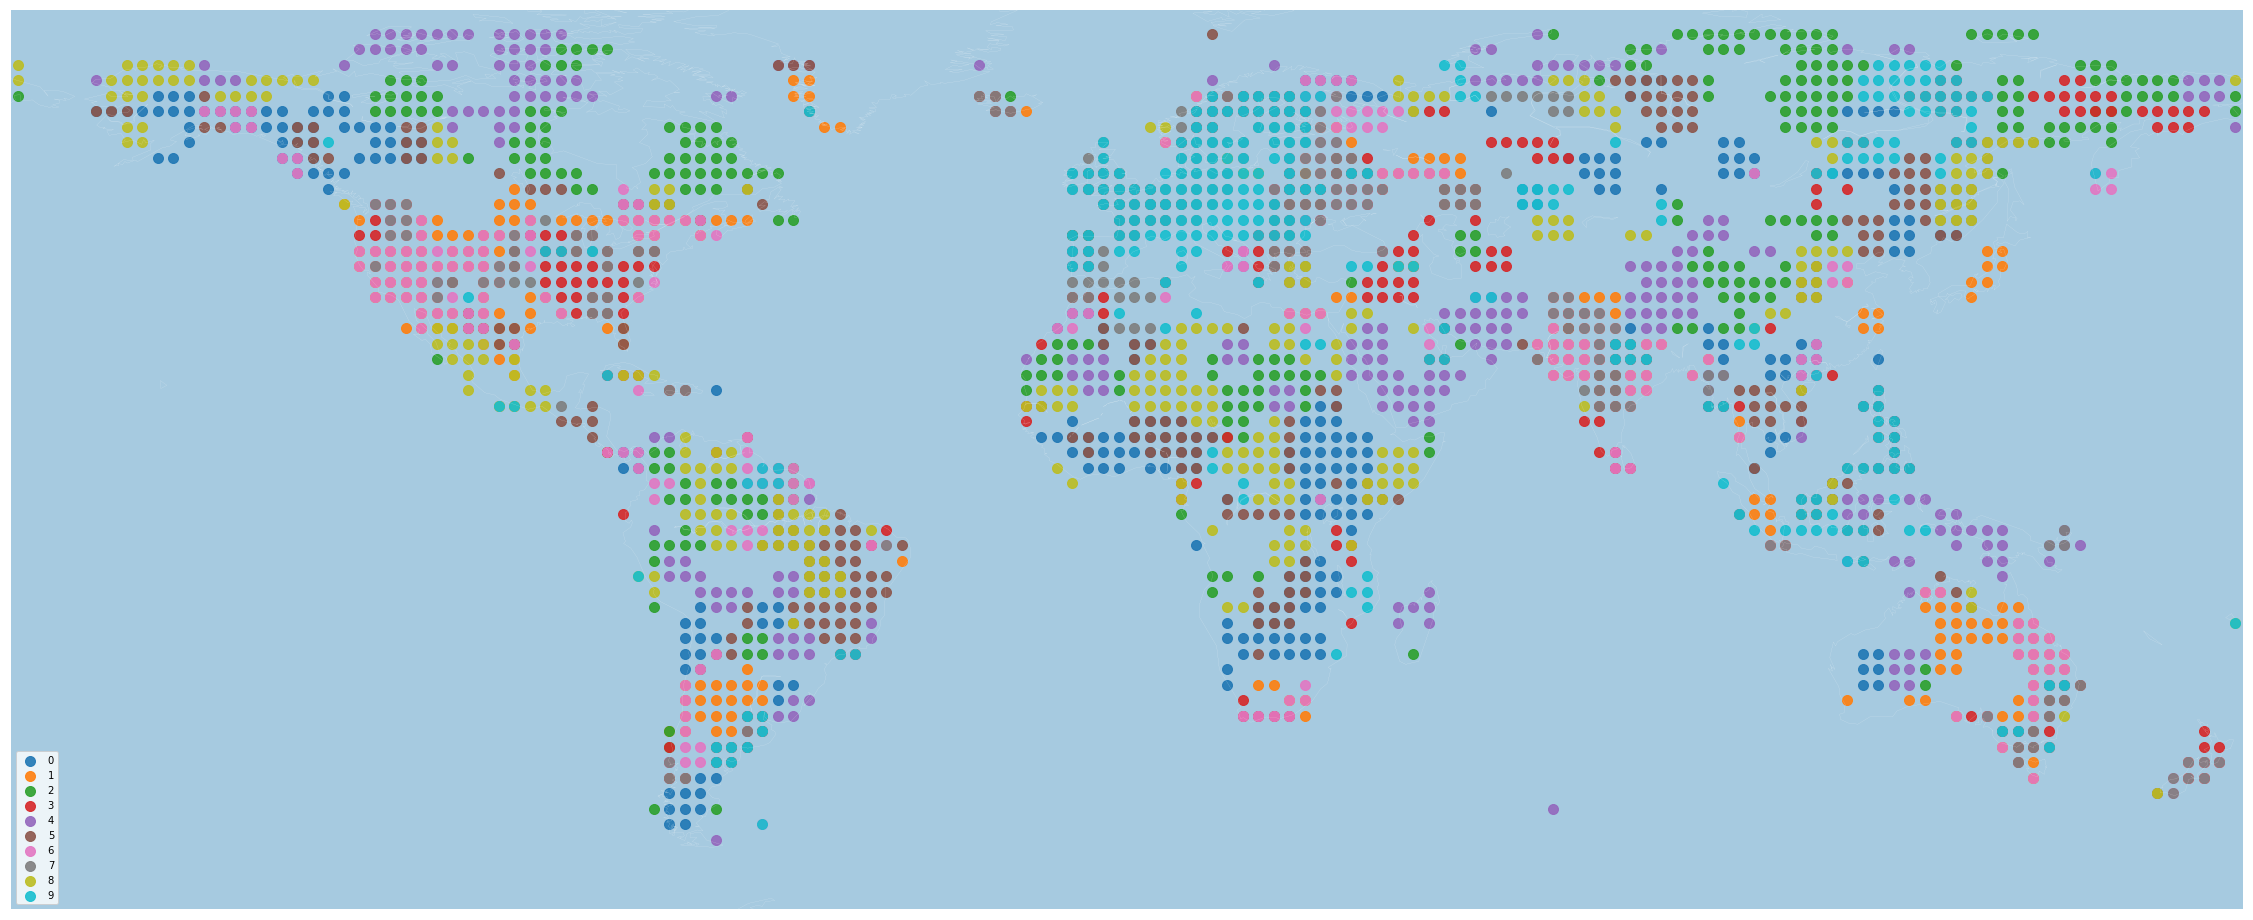

In [11]:
limit = 0.99

df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
#m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

limit = 0.9

for i in range(n_components):
    values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=100, label = i)

    
plt.legend()
plt.show()
#plt.savefig("world_clusters.png")

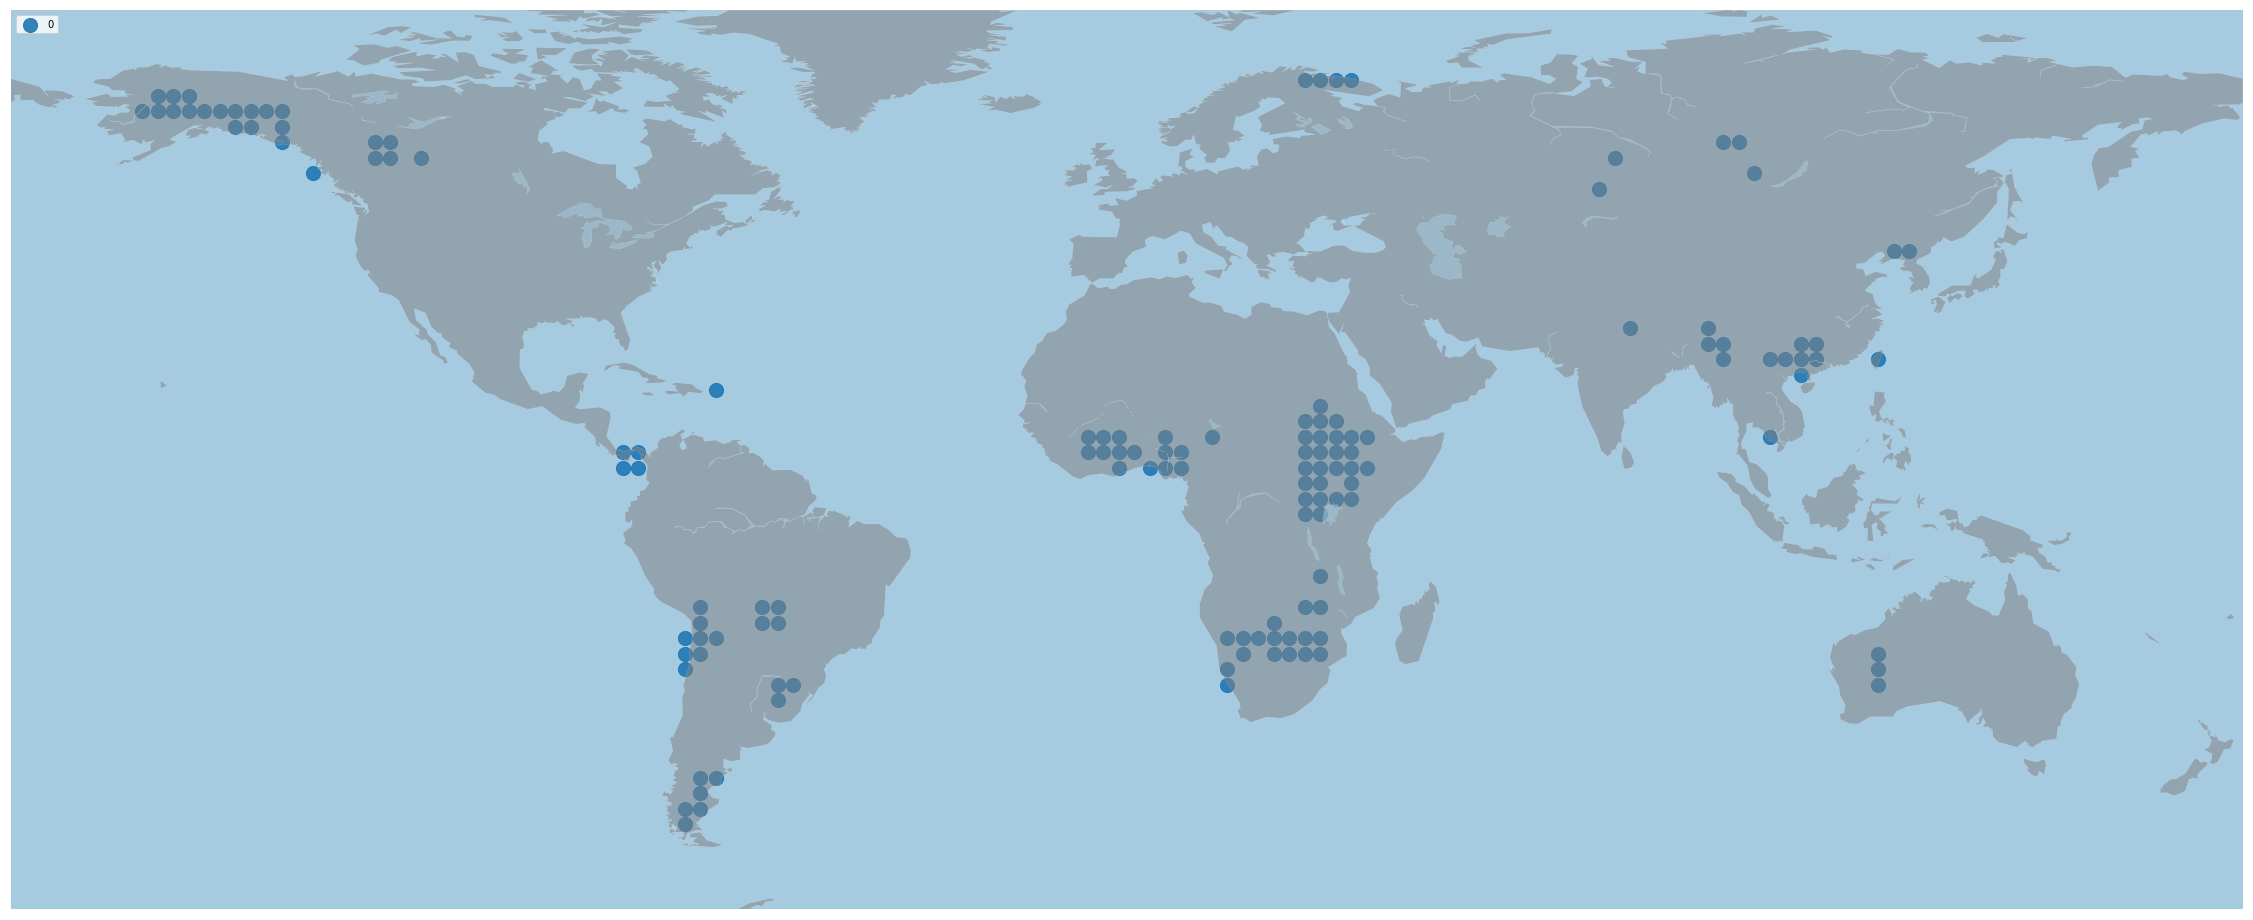

In [12]:
limit = 0.95

i = 0
df1 = pd.DataFrame(columns=df.columns)

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(40,20))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

values,Idx = pf.index_finder_percentile(loading,i, percentile= limit)
df1 = df.iloc[Idx,:]
df1["values"] = values

lons = df1["lons"].values
lats = df1["lats"].values
x,y = m(lons, lats)
ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [13]:
var_names = loading.columns
result = result.dot(loading)
result = np.matrix(result)

In [14]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [15]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 10 link(s):
        (0 -1): pval = 0.00000 | val = 0.642
        (1 0): pval = 0.00000 | val = -0.361
        (8 0): pval = 0.00000 | val = -0.274
        (9 0): pval = 0.00000 | val = 0.209
        (4 0): pval = 0.00000 | val = 0.180
        (2 0): pval = 0.00000 | val = -0.161
        (5 0): pval = 0.00000 | val = -0.151
        (7 0): pval = 0.00000 | val = 0.111
        (6 0): pval = 0.00899 | val = -0.059
        (1 -1): pval = 0.04480 | val = -0.045

    Variable 1 has 12 link(s):
        (1 -1): pval = 0.00000 | val = 0.584
        (4 0): pval = 0.00000 | val = -0.463
        (0 0): pval = 0.00000 | val = -0.361
        (2 0): pval = 0.00000 | val = -0.332
        (8 0): pval = 0.00000 | val = 0.242
        (7 0): pval = 0.00000 | val = -0.197
        (5 0): pval = 0.00000 | val = -0.127
        (9 0): pval = 0.00000 | val = -0.121
        (6 0): pval = 0.00125 | val = 0.073
        (3 0): pval = 0.00373 | val = 0.065
  

In [16]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 9 link(s):
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.642
        (1 0): pval = 0.00000 | qval = 0.00000 | val = -0.361
        (8 0): pval = 0.00000 | qval = 0.00000 | val = -0.274
        (9 0): pval = 0.00000 | qval = 0.00000 | val = 0.209
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.180
        (2 0): pval = 0.00000 | qval = 0.00000 | val = -0.161
        (5 0): pval = 0.00000 | qval = 0.00000 | val = -0.151
        (7 0): pval = 0.00000 | qval = 0.00000 | val = 0.111
        (6 0): pval = 0.00899 | qval = 0.00899 | val = -0.059

    Variable 1 has 10 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.584
        (4 0): pval = 0.00000 | qval = 0.00000 | val = -0.463
        (0 0): pval = 0.00000 | qval = 0.00000 | val = -0.361
        (2 0): pval = 0.00000 | qval = 0.00000 | val = -0.332
        (8 0): pval = 0.00000 | qval = 0.00000 | val = 0.242
        (7 0): pval = 0.00000 | qv

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80529ec630>)

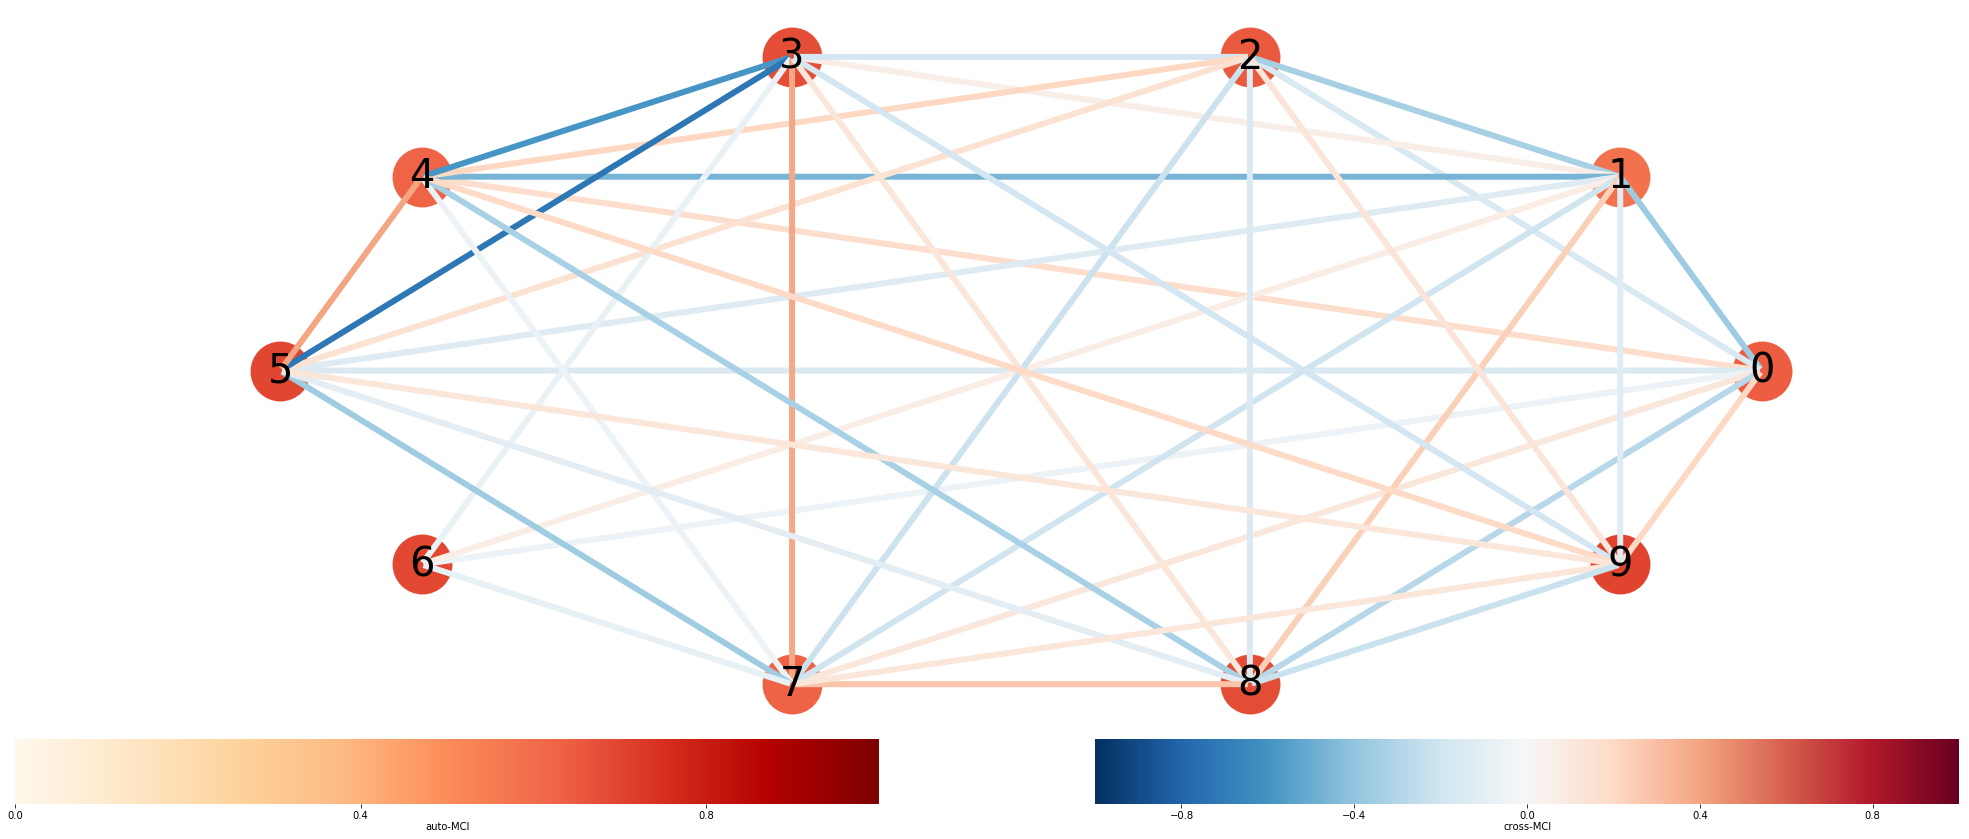

In [17]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 20,
    node_size = 60
    )

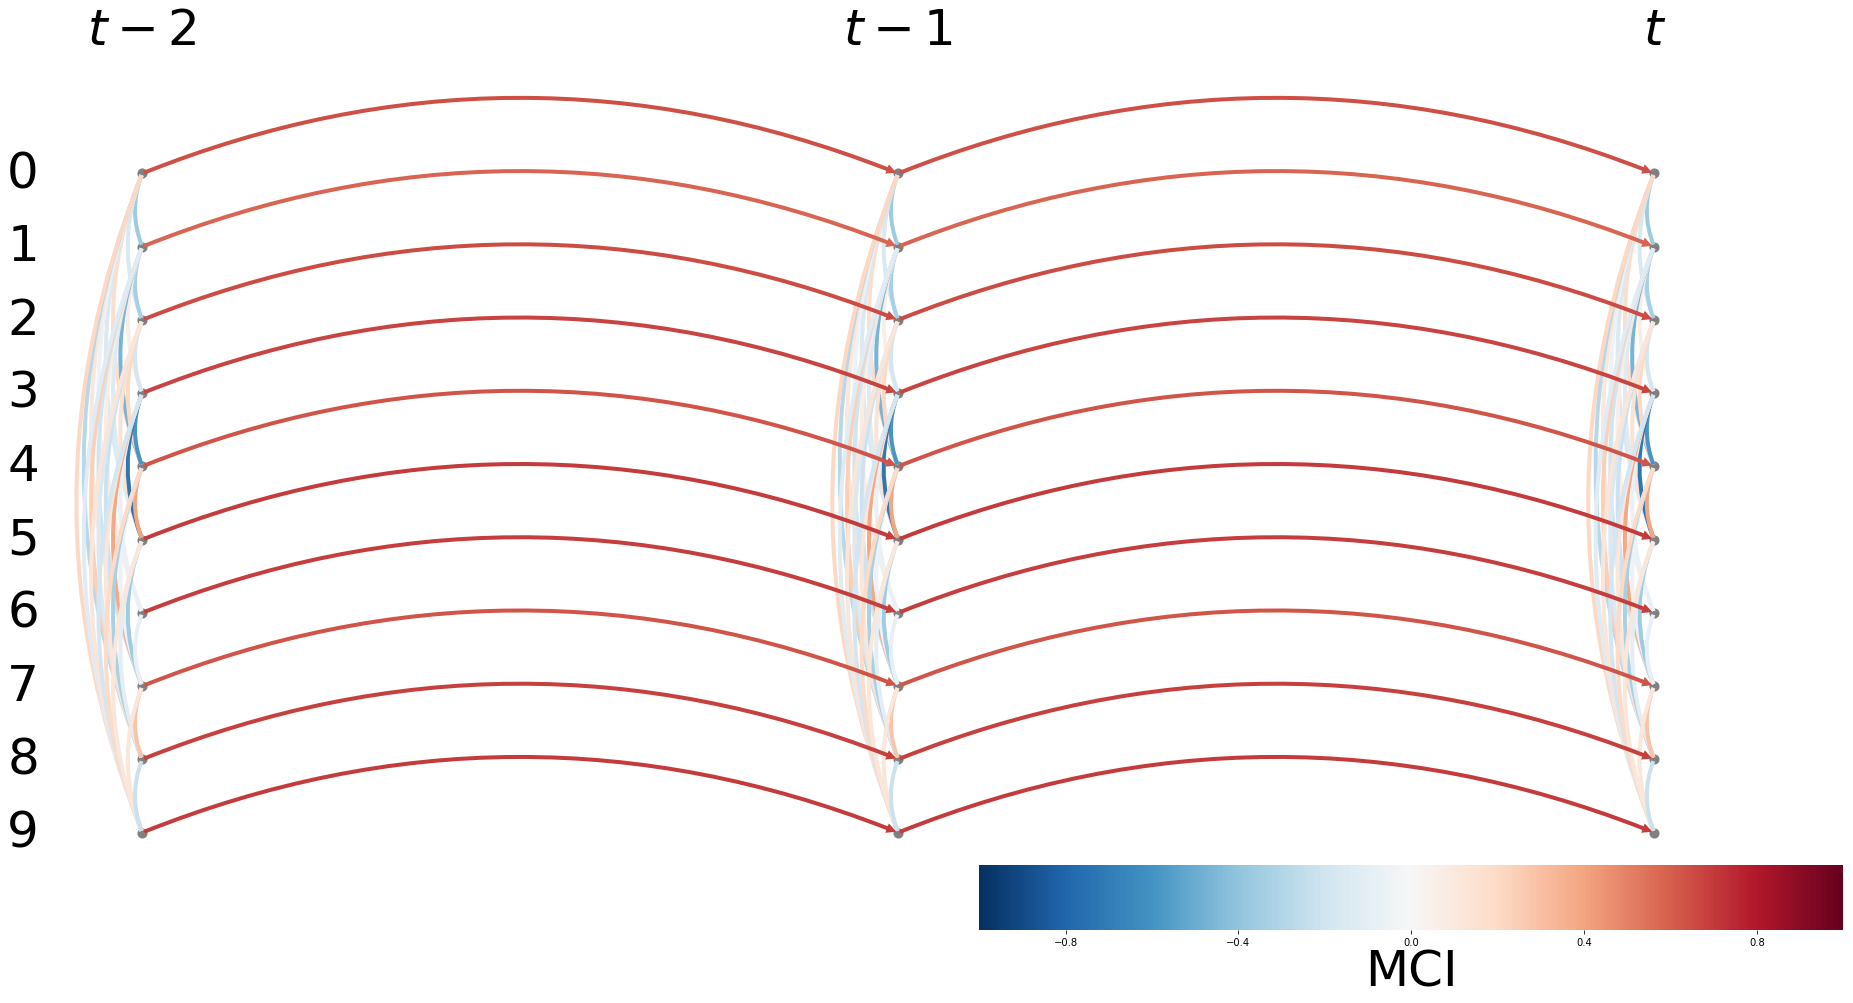

In [18]:
tp.plot_time_series_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='MCI',figsize=(30,15),
    node_label_size=100,
    label_fontsize = 50
    )